In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_absolute_percentage_error

# Read the data
df = pd.read_csv("/content/merged_cleaned.csv", delimiter=",")

# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("[MWh]", "")

df = df.drop('date',axis=1)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# One-hot encode 'Holiday' and 'day_name' columns
df = pd.get_dummies(df, columns=['Holiday', 'day_name'], drop_first=True)

# Fill missing values with forward fill
df = df.fillna(method='ffill')

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Date']))

# Add back the scaled data to the DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled['Date'] = df['Date']

# Split the data into train, validation, and test
train = df_scaled[df_scaled['Date'] < '2023-10-30']
test = df_scaled[df_scaled['Date'] >= '2023-10-30']

# Optional: Split the train set into training and validation
val = train.tail(len(train)//10)
train = train.head(len(train) - len(val))


<ipython-input-1-11d44ce1502c>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [15]:
df.columns

Index(['Date', 'Gesamt_(Netzlast)__Berechnete_Auflösungen',
       'Deutschland/Luxemburg_[€/MWh]_Originalauflösungen',
       'Biomasse__Berechnete_Auflösungen',
       'Wasserkraft__Berechnete_Auflösungen',
       'Wind_Offshore__Berechnete_Auflösungen',
       'Wind_Onshore__Berechnete_Auflösungen',
       'Photovoltaik__Berechnete_Auflösungen',
       'Sonstige_Erneuerbare__Berechnete_Auflösungen',
       'Kernenergie__Berechnete_Auflösungen',
       'Braunkohle__Berechnete_Auflösungen',
       'Steinkohle__Berechnete_Auflösungen', 'Erdgas__Berechnete_Auflösungen',
       'Pumpspeicher__Berechnete_Auflösungen_y',
       'Sonstige_Konventionelle__Berechnete_Auflösungen', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'date_offset',
       'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
       'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'is_workday',
       'Holiday_Christmas Day', 'Holiday_Day of German Unity',
       'Ho

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch import nn

# Create dataset class for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=48):
        self.data = data
        self.window_size = window_size
        self.features = data.drop(columns=['Date']).values
        self.target = data['Gesamt_(Netzlast)__Berechnete_Auflösungen'].values

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.window_size]
        y = self.target[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Set window size for LSTM (48 hours = 2 days of data)
window_size = 48

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train, window_size)
val_dataset = TimeSeriesDataset(val, window_size)
test_dataset = TimeSeriesDataset(test, window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [5]:
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # get the last time step
        return self.fc(lstm_out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [7]:
# Define the model and trainer
model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=64)

# Initialize the TensorBoard logger
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="lstm_model")

trainer = pl.Trainer(max_epochs=100, devices=1, accelerator="gpu", logger=logger)

# Train the model
trainer.fit(model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 28.7 K | train
1 | fc   | Linear | 65     | train
----------------------------------------
28.7 K    Trainable params
0         Non-trainable params
28.7 K    Total params
0.115     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
# Test the model on the test set
predictions, targets = [], []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        predictions.append(y_hat.squeeze().numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

# Calculate MAPE
mape = mean_absolute_percentage_error(targets, predictions)
print(f'MAPE on test data: {mape:.4f}')


MAPE on test data: 0.0448


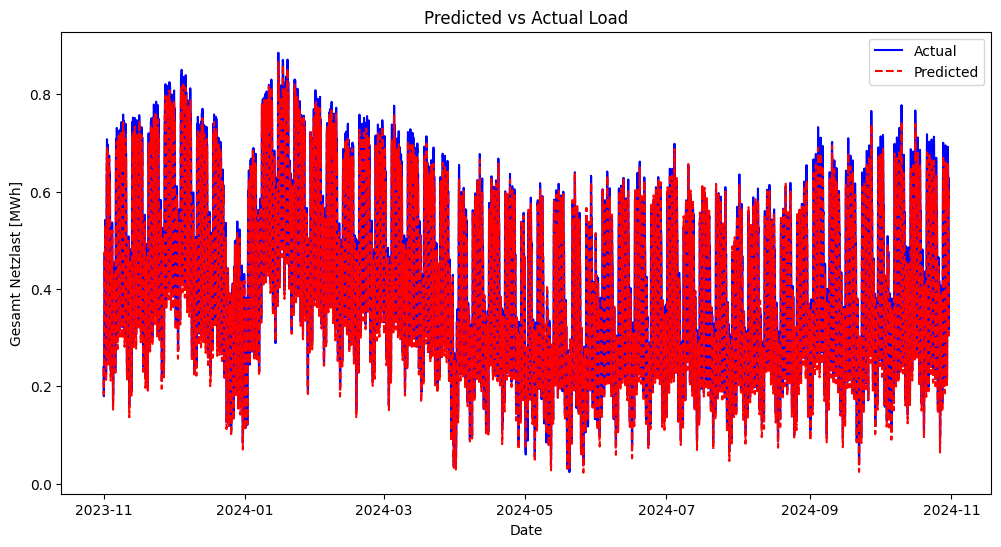

In [9]:
import matplotlib.pyplot as plt

# Convert to a DataFrame for plotting
pred_df = pd.DataFrame({'Date': test['Date'][window_size:].values, 'Actual': targets, 'Predicted': predictions})

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df['Date'], pred_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gesamt Netzlast [MWh]')
plt.title('Predicted vs Actual Load')
plt.legend()
plt.show()
